In [1]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

# Objective: predict unit_sales to optimize supply / stock

# load data

In [2]:
# df_train = pd.read_csv('train.csv', dtype={'onpromotion': bool},
#                        converters={'unit_sales': lambda u: np.log1p(float(u)) if float(u) > 0 else 0},
#                        parse_dates=["date"], skiprows=range(1, 66458909))

In [3]:
#df_train = df_train_raw.loc[df_train_raw['date']>=pd.datetime(2016,1,1)]

In [4]:
# train on 2017 data
df_train = pd.read_csv('train.csv', dtype={'onpromotion': bool},
                       converters={'unit_sales': lambda u: np.log1p(float(u)) if float(u) > 0 else 0},
                       parse_dates=["date"], skiprows = range(1,101688780))

In [5]:
print(df_train.shape)
df_train.head()

(23808261, 6)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,101688779,2017-01-01,25,99197,0.693147,False
1,101688780,2017-01-01,25,103665,2.079442,False
2,101688781,2017-01-01,25,105574,0.693147,False
3,101688782,2017-01-01,25,105857,1.609438,False
4,101688783,2017-01-01,25,106716,1.098612,False


In [6]:
# create index for the date range
date_index = pd.date_range(df_train['date'].min(), df_train['date'].max())

In [7]:
df_test = pd.read_csv("test.csv", dtype={'onpromotion': bool}, parse_dates=["date"]).set_index(['store_nbr', 'item_nbr', 'date'])

In [8]:
print(df_test.shape)
df_test.head()

(3370464, 2)


id  onpromotion
store_nbr item_nbr date                              
1         96995    2017-08-16  125497040        False
          99197    2017-08-16  125497041        False
          103501   2017-08-16  125497042        False
          103520   2017-08-16  125497043        False
          103665   2017-08-16  125497044        False

In [9]:
items = pd.read_csv("items.csv").set_index("item_nbr")
items.head()

,family,class,perishable
item_nbr,,,
96995,GROCERY I,1093,0
99197,GROCERY I,1067,0
103501,CLEANING,3008,0
103520,GROCERY I,1028,0
103665,BREAD/BAKERY,2712,1


# EDA

## Pattern in Time Series?

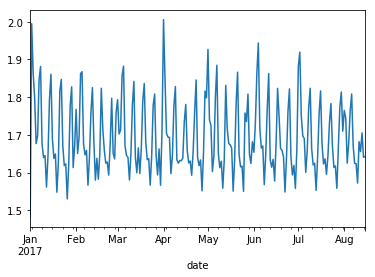

In [10]:
df_train.groupby('date')['unit_sales'].mean().plot()

In [11]:
df_train['dow'] = df_train['date'].dt.dayofweek

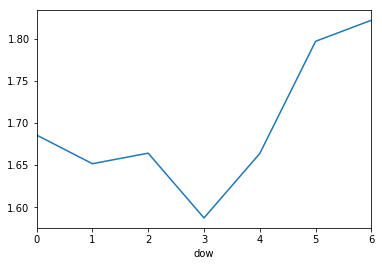

In [12]:
df_train.groupby('dow')['unit_sales'].mean().plot()

In [13]:
df_train['month'] = df_train['date'].dt.month

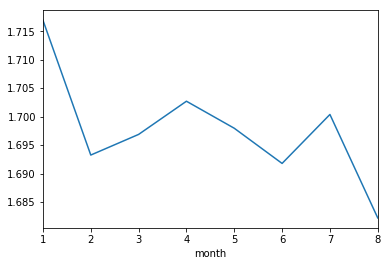

In [14]:
df_train.groupby('month')['unit_sales'].mean().plot()

In [15]:
date_index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=227, freq='D')

In [16]:
df_train['dom'] = df_train['date'].dt.day

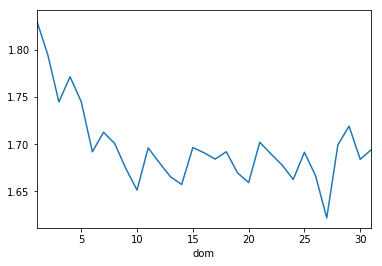

In [17]:
df_train.groupby('dom')['unit_sales'].mean().plot()

## store

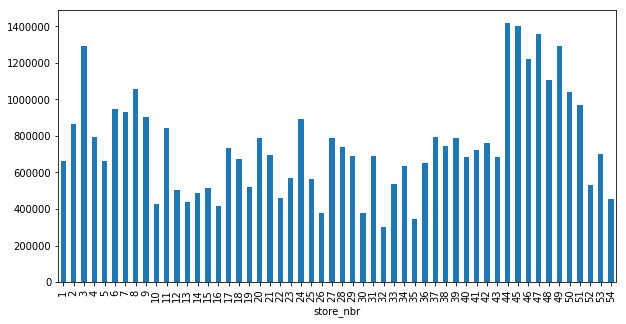

In [18]:
store_sum = df_train.groupby('store_nbr')['unit_sales'].sum()
store_sum.plot.bar(figsize = (10,5))

In [19]:
# select stores by highest, 75%, median, 25%
store_sum.sort_values(ascending = False, inplace = True)
i_sample = store_sum.index.values[[0, store_sum.shape[0]//4, store_sum.shape[0]//2, store_sum.shape[0]//4 * 3]]

In [20]:
df_sample = df_train.loc[df_train['store_nbr'].isin(i_sample), :].groupby(['date', 'store_nbr'])['unit_sales'].sum()

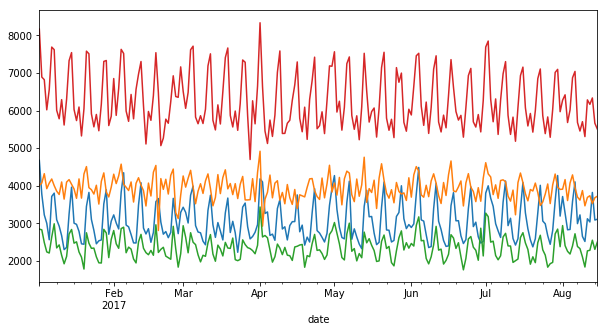

In [21]:
df_sample.unstack(level=-1).fillna(0).plot(figsize = (10, 5), legend = False)

## item (SKU)

9078.15808185801


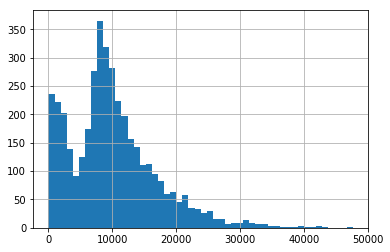

In [22]:
item_rank = df_train.groupby('item_nbr')['unit_sales'].sum().sort_values(ascending = False)
item_rank.hist(bins = 50)
print(item_rank.median())

In [23]:
# sample highest, 75%, median, 25%
i_sample = item_rank.index.values[[0, item_rank.shape[0]//4, item_rank.shape[0]//2, item_rank.shape[0]//4 * 3]]

In [24]:
df_sample = df_train.loc[df_train['item_nbr'].isin(i_sample), :].groupby(['date', 'item_nbr'])['unit_sales'].sum()

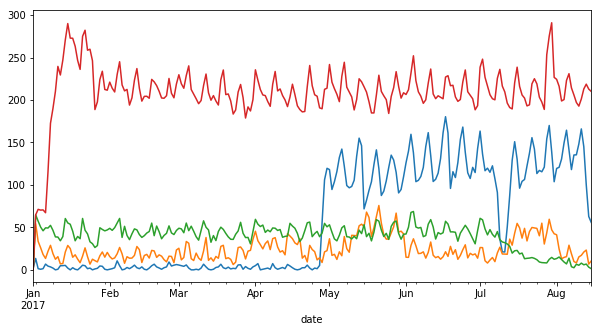

In [25]:
df_sample.unstack(level=-1).fillna(0).plot(figsize = (10, 5), legend = False)

In [26]:
items.loc[i_sample]

,family,class,perishable
item_nbr,,,
2042947,BEVERAGES,1148,0
219150,BEVERAGES,1122,0
1353969,CLEANING,3020,0
1261025,BEVERAGES,1124,0


In [27]:
items.loc[[219150, 269029]]

,family,class,perishable
item_nbr,,,
219150,BEVERAGES,1122,0
269029,BEVERAGES,1122,0


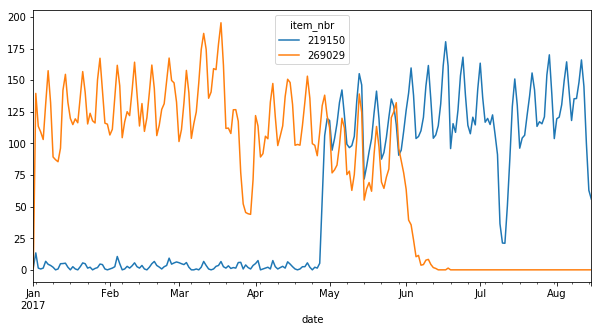

In [28]:
df_sample = df_train.loc[df_train['item_nbr'].isin([219150, 269029]), :].groupby(['date', 'item_nbr'])['unit_sales'].sum()
df_sample.unstack(level=-1).fillna(0).plot(figsize = (10, 5))

In [29]:
df_train = df_train.merge(items.reset_index(), how = 'left', on = 'item_nbr')

In [30]:
df_family = df_train.groupby('family')['unit_sales'].sum()

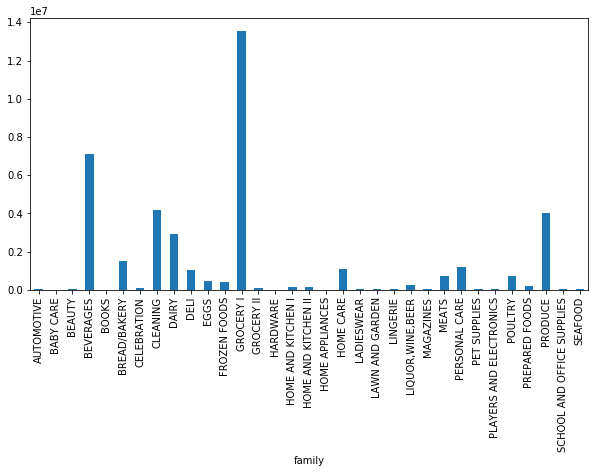

In [31]:
df_family.plot.bar(figsize = (10, 5))

In [32]:
df_family = df_family.sort_values(ascending = False)

In [33]:
i_sample = df_family.index.values[:5]

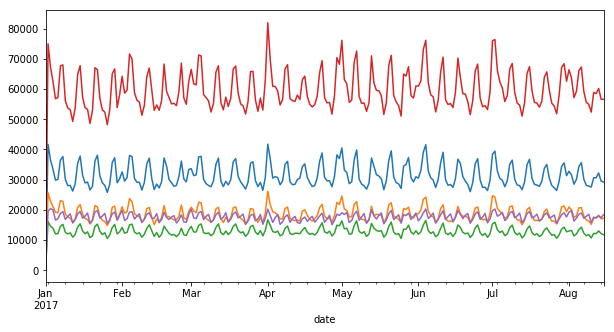

In [34]:
df_sample = df_train.loc[df_train['family'].isin(i_sample), :].groupby(['date', 'family'])['unit_sales'].sum()
df_sample.unstack(level=-1).fillna(0).plot(figsize = (10, 5), legend = False)